In [1]:
%matplotlib notebook

import os
import json
import dask
import multiprocessing
import sys
import numpy as np
import matplotlib.pyplot as plt
from SimPEG import (
    Mesh, Utils, Maps, Regularization,
    DataMisfit, Inversion, InvProblem, Directives, Optimization,
    )
from SimPEG.Utils import mkvc, matutils, modelutils
import SimPEG.PF as PF
from discretize.utils import meshutils
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator
from scipy.spatial import cKDTree, ConvexHull
from scipy.linalg import lstsq

In [2]:
work_dir = r"C:\Users\DominiqueFournier\Dropbox\Projects\Synthetic\Block_Gaussian_topo"
data_file = "Obs_loc_TMI.obs"
topo_file = "Gaussian.topo"



# Import data
survey = Utils.io_utils.readUBCmagneticsObservations(work_dir + os.sep + data_file)[0]
topo = np.loadtxt(work_dir + os.sep + topo_file, skiprows=1)

In [3]:
padding_distance = [[200, 200], [200, 200], [1000, 0]]
core_cell_size = [20, 20, 20]
inversion_mesh_type = "TREE"
input_mesh = None
depth_core = 300
octree_levels_topo = [0, 2]
octree_levels_obs = [5]
octree_levels_padding = [5]
max_distance = 500

# Make a mesh
mesh = meshutils.mesh_builder_xyz(
        survey.rxLoc,
        core_cell_size,
        padding_distance=padding_distance,
        mesh_type=inversion_mesh_type,
        base_mesh=input_mesh,
        depth_core=depth_core
    )

mesh = meshutils.refine_tree_xyz(
    mesh, topo, method='surface',
    octree_levels=octree_levels_topo, finalize=False
)

mesh = meshutils.refine_tree_xyz(
    mesh, survey.rxLoc, method='surface',
    max_distance=max_distance,
    octree_levels=octree_levels_obs,
    octree_levels_padding=octree_levels_padding,
    finalize=True,
)

In [5]:


activeCells = Utils.surface2ind_topo(mesh, topo, gridLoc='CC')
nC = int(np.sum(activeCells))

mref = np.zeros(nC)

reg_map = Maps.IdentityMap(nP=nC)
prob = PF.Magnetics.MagneticIntegral(
            mesh, chiMap=reg_map, actInd=activeCells,
)

survey.unpair()
survey.pair(prob)

misfit = DataMisfit.l2_DataMisfit(survey)
misfit.W = 1./survey.std
    
wr = prob.getJtJdiag(np.ones_like(mref), W=misfit.W)**0.5
wr /= wr.max()

activeCellsMap = Maps.InjectActiveCells(
    mesh, activeCells, -1
)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
Begin forward: M=H0, Rx type= ['tmi']
DASK: Chunking by columns
Tile size (nD, nC):  (616, 2645)
Number of chunks: 1 x 1 = 1
Target chunk size: 128 MB
Max chunk size 616 x 2645 = 13.035 MB
Min chunk size 616 x 2645 = 13.035 MB
Max RAM (GB x 8 CPU): 0.104276
Tile size (GB): 0.013
Zarr file detected with same shape and chunksize ... re-loading


In [7]:
reg = Regularization.Sparse(
    mesh,
    indActive=activeCells,
    mapping=reg_map,
    )
reg.cell_weights = wr
reg.mref = mref


# Specify how the optimization will proceed, set susceptibility bounds to inf
opt = Optimization.ProjectedGNCG(
    maxIter=20, lower=0, upper=10,
    maxIterLS=20, maxIterCG=30, tolCG=1e-3
)

# Create the default L2 inverse problem from the above objects
invProb = InvProblem.BaseInvProblem(misfit, reg, opt)

# Add a list of directives to the inversion
directiveList = []

# Save model
directiveList.append(Directives.SaveOutputEveryIteration(save_txt=False))
directiveList.append(Directives.SaveUBCModelEveryIteration(
    mapping=activeCellsMap,
    mesh=mesh,
    fileName=work_dir + "Mag",
)
)


directiveList.append(Directives.BetaEstimate_ByEig(beta0_ratio=1e+1))

# Pre-conditioner
update_Jacobi = Directives.UpdatePreconditioner()

IRLS = Directives.Update_IRLS(
                        f_min_change=1e-3, minGNiter=1, beta_tol=0.25,
                        maxIRLSiter=1,
                        chifact_target=1,
                        betaSearch=False)

# Put all the parts together
inv = Inversion.BaseInversion(
    invProb, directiveList=directiveList + [IRLS, update_Jacobi]
)

# SimPEG reports half phi_d, so we scale to matrch
# Run the inversion
mrec = inv.run(np.ones(nC)*1e-3)



SimPEG.SaveModelEveryIteration will save your models in UBC format as: '###-C:\Users\DominiqueFournier\Dropbox\Projects\Synthetic\Block_Gaussian_topoMag.mod'
Use Simple
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.63e+12  2.12e+07  5.52e-05  1.11e+08    2.65e+02      0              
Start CG solve
CG solve time: 2.4405007362365723
   1  8.17e+11  2.58e+05  2.75e-08  2.81e+05    2.99e+02      0              
Start CG solve
CG solve time: 2.646040201187134
   2  4.09e+11  2.11e+05  6.80e-08  2.39e+05    2.78e+02      0              
Start CG solve
CG solve time: 2.5430002212524414
   3  2.04e+11  1.66e+05  1.49e-07  1.96e+05    2.86e+02      0   Skip BFGS  
Start CG solve
CG solve time: 2.6155014038085938
   4  

C:\Users\DominiqueFournier\Documents\GIT\SimPEG\SimPEG\Directives.py:920: RuntimeWarning: invalid value encountered in double_scalars
  self.f_change = np.abs(self.f_old - phim_new) / self.f_old


  12  3.99e+08  1.93e+02  3.75e-06  1.69e+03    3.67e+02      0   Skip BFGS  
Start CG solve
CG solve time: 2.6005020141601562
Reach maximum number of IRLS cycles: 1
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.1141e+07
1 : |xc-x_last| = 3.6585e-04 <= tolX*(1+|x0|) = 1.0514e-01
0 : |proj(x-g)-x|    = 3.6726e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.6726e+02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      20    <= iter          =     13
------------------------- DONE! -------------------------


<IPython.core.display.Javascript object>


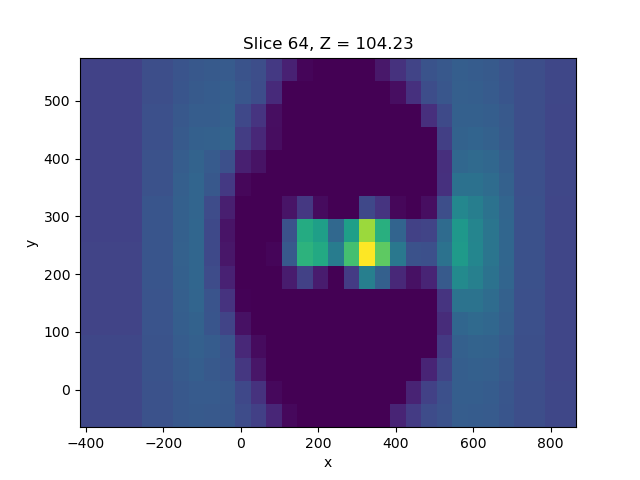

(<matplotlib.cm.ScalarMappable at 0x1f2dcc0b108>,)

In [8]:
mesh.plotSlice(activeCellsMap*mrec)
